In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA, ARMA
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D 
from keras.layers import LSTM 
from sklearn.metrics import mean_squared_error
from math import sqrt
from numpy import mean
from sklearn.model_selection import train_test_split 

Using TensorFlow backend.


# Data Manipulation

## Data Setup

I will start off by reading in two different datasets. This is because I will be comparing the performance of models using these two sets consistently throughout this project. Both datasets contain univariate time series data. One of the datasets represents the solar power for a year in Nevada and the other represents the saem in Louisiana.

In [2]:
nev_data = pd.read_csv("Actual_36.15_-115.45_2006_UPV_142MW_5_Min Nevada.csv")
lou_data = pd.read_csv("Actual_29.15_-90.15_2006_UPV_140MW_5_Min Louisisana.csv")

The data_setup function allows me to manipulate the data so that it is set up in a particular way regarding the index and column names

In [3]:
def data_setup(df):
    
    df['LocalTime'] = pd.to_datetime(df['LocalTime'])
    df.set_index('LocalTime', inplace=True)
    df.columns = ['power']
    df.index.names = ['time']

    return df

In [4]:
nev_data = data_setup(nev_data)
lou_data = data_setup(lou_data)

## Data Splitting

The df_split function allows me to take a subset of an existing dataset by identifying a particular month of the year. The vaiability of the weather is different depending on the month and so comparing the model performances for several months will allow us to assess the performance using lots of different data. A new column is also created in this function which is equal to the difference in solar power from exactly 24 hours previously. This is becauses the data is known to be stationary due to it's nature and so this removes stationarity as a potential problem.

The df_plot function plots a data fram so that we can visualise it. We can see from below that the Nevada data for the month of January no longer features no stationarity.

In [5]:
def df_split(df, month):
    
    df_month = df[df.index.month == month]
    df_month = df_month.between_time('06:00','18:00')
    df_month['stationary'] = df_month['power'].diff(144)

    return df_month

def df_plot(df):
    
    plt.plot(df['stationary'].dropna())
    plt.xticks(rotation = 45)
    plt.show()

In [6]:
jan_nev = df_split(nev_data, 1)
apr_nev = df_split(nev_data, 4)
jul_nev = df_split(nev_data, 7)
oct_nev = df_split(nev_data, 10)

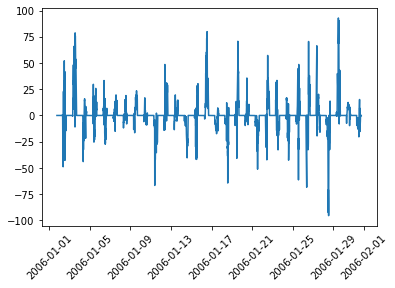

In [7]:
df_plot(jan_nev)

## Data Visualisation

The plot_histograms function will plot four datasets in a histogram. This will show us how the data is spread between values and allow us to compare different months against each other. It is clear from below that for October and November, there are a lot of values in the range of zero to ten which is unsrurprising as it is during a time of the year with lower levels of sun.

The plot_boxplots function will produce boxplots for four datasets. The point of the boxplot is to show the variation within a dataset. It provides us with information about the minimum and maximum values as well as where each of the quartiles are located.

In [8]:
def plot_histograms(df1, df2, df3, df4):
    
    plt.figure(figsize = (12,10))
    plt.subplot(221)
    plt.hist(jan_nev["power"])
    plt.title("Histogram of January Solar Power (MW)")
    plt.subplot(222)
    plt.hist(apr_nev["power"])
    plt.title("Histogram of April Solar Power (MW)")
    plt.subplot(223)
    plt.hist(jul_nev["power"])
    plt.title("Histogram of July Solar Power (MW)")
    plt.subplot(224)
    plt.hist(oct_nev["power"])
    plt.title("Histogram of October Solar Power (MW)")
    plt.show()

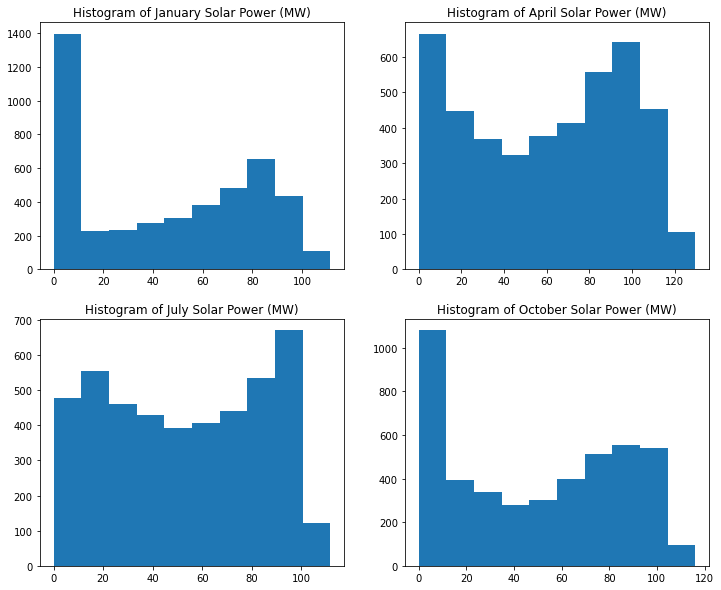

In [9]:
plot_histograms(jan_nev, apr_nev, jul_nev, oct_nev)

In [21]:
def plot_boxplots(df1, df2, df3, df4):
    plt.figure(figsize = (12,10))
    plt.subplot(221)
    plt.boxplot(jan_nev["power"])
    plt.title("Boxplot of %s Solar Power (MW)" % df1)
    plt.xticks([1], [''])
    plt.subplot(222)
    plt.boxplot(apr_nev["power"])
    plt.title("Boxplot of Nevada April Solar Power (MW)")
    plt.xticks([1], [''])
    plt.subplot(223)
    plt.boxplot(jul_nev["power"])
    plt.title("Boxplot of Nevada July Solar Power (MW)")
    plt.xticks([1], [''])
    plt.subplot(224)
    plt.boxplot(oct_nev["power"])
    plt.title("Boxplot of Nevada October Solar Power (MW)")
    plt.xticks([1], [''])
    plt.show()

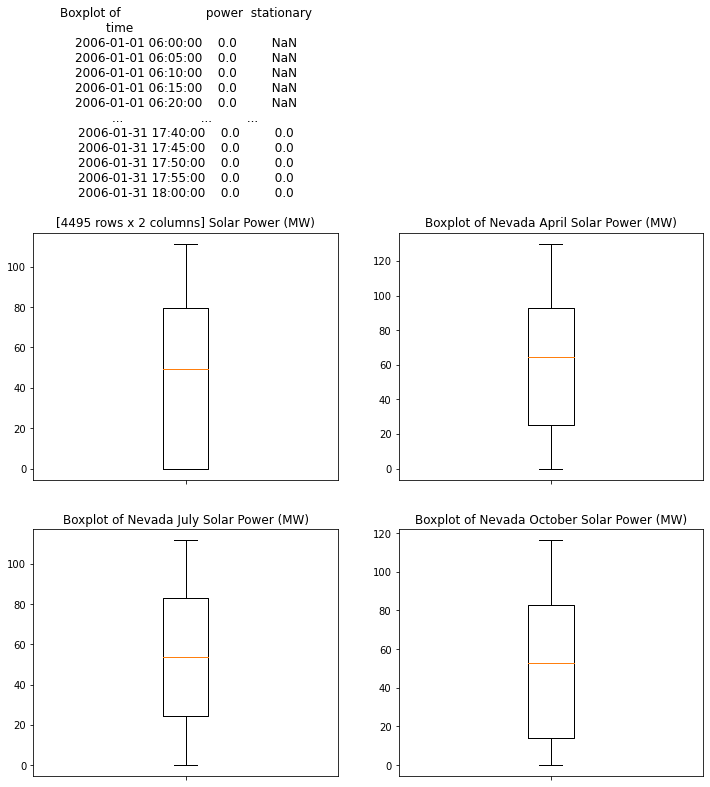

In [22]:
plot_boxplots(jan_nev, apr_nev, jul_nev, oct_nev)

# Models

## Time Series Models

**AUTOREGRESSIVE**

In [12]:
def ar(data, length):
    X = data
    train, test = X[0:-720], X[len(X) - length * 144:]

    for ar in range(1,11):
        history = [x for x in train]
        predictions = list()
        for i in range(len(test)):
            model = ARMA(history, order=(ar, 0)) 
            model_fit = model.fit(disp=0)
            yhat = model_fit.forecast()[0] 
            predictions.append(yhat)
            # observation
            obs = test[i]
            history.append(obs)

        rmse = sqrt(mean_squared_error(test, predictions)) 
        print('AR %d' % ar, 'RMSE: %.3f' % rmse)

**MOVING AVERAGE**

In [13]:
def ma(data, length):
    X = data
    train, test = X[0:-720], X[len(X) - length * 144:]

    for ma in range(1,11):
        history = [x for x in train]
        predictions = list()
        for i in range(len(test)):
            model = ARMA(history, order=(0, ma)) 
            model_fit = model.fit(disp=0)
            yhat = model_fit.forecast()[0] 
            predictions.append(yhat)
            obs = test[i]
            history.append(obs)

        rmse = sqrt(mean_squared_error(test, predictions)) 
        print('MA %d' % ma, 'RMSE: %.3f' % rmse)

**AUTOREGRESSIVE MOVING AVERAGE**

In [14]:
def arma(data, length):
    
    X = data
    train, test = X[0:-720], X[len(X) - length * 144:]

    for ar in range(1,11):
        for ma in range(1,11):
            # walk-forward validation
            history = list()
            history = [x for x in train]
            predictions = list()
            for i in range(len(test)):
                try:
                    model = ARMA(history, order=(ar,ma)) 
                    model_fit = model.fit(disp=0)
                    yhat = model_fit.forecast()[0] 
                    predictions.append(yhat)
                    # observation
                    obs = test[i]
                    history.append(obs)
            
                except:
                    pass
            
            try:
                rmse = sqrt(mean_squared_error(test, predictions)) 
                print('ARMA %d' % ar, '%d' % ma, 'RMSE: %.3f' % rmse)
        
            except:
                pass

**AUTOREGRESSIVE INTEGRATED MOVING AVERAGE**

In [15]:
def arima(data, length):
    
    X = data
    train, test = X[0:720], X[len(X) - length * 144:]

    for ar in range(1,11):
        for ma in range(1,11):
            for d in range(1,3):
                # walk-forward validation
                history = [x for x in train]
                predictions = list()
                for i in range(len(test)):
                    try:
                        model = ARIMA(history, order=(ar,d,ma)) 
                        model_fit = model.fit(disp=0)
                        yhat = model_fit.forecast()[0] 
                        predictions.append(yhat)
                        # observation
                        obs = test[i]
                        history.append(obs)
                    except:
                        pass
                
                try:
                    rmse = sqrt(mean_squared_error(test, predictions)) 
                    print('ARIMA %d' % ar, '%d' % d, '%d' % ma, 'RMSE: %.3f' % rmse)
                
                except:
                    pass

## Deep Learning Models

**MULTI-LAYER PERCEPTRON**

In [16]:
def mlp(data, testing_size, n):
    
    shifted_data = pd.DataFrame()
    
    for i in range(n, -1, -1):
        shifted_data[i] = data.shift(i)

    shifted_data = shifted_data.dropna()
    
    X = shifted_data.drop(0, axis=1).values
    y = shifted_data[0].values
    
    if testing_size == 1:
        test_size = float(144 / len(X))
    elif testing_size == 3:
        test_size = float(432 / len(X))
    elif testing_size == 5:
        test_size = float(720 / len(X))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, shuffle = False)

    model = Sequential()
    model.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dense(1))
    model.compile(loss='rmse', optimizer='adam')
    
    results = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, verbose=2)
    rmse = mean(results.history['val_loss'])
    
    print('RMSE = %.3f' %(rmse))

**CONVOLUTIONAL NEURAL NETWORK** 

In [17]:
def cnn(data, testing_size, n):   
    
    shifted_data = pd.DataFrame()

    for i in range(n, -1, -1):
        shifted_data[i] = data.shift(i)
        
    shifted_data = shifted_data.dropna()

    X = shifted_data.drop(0, axis=1).values
    y = shifted_data[0].values
    
    if testing_size == 1:
        test_size = float(144 / len(X))
    elif testing_size == 3:
        test_size = float(432 / len(X))
    elif testing_size == 5:
        test_size = float(720 / len(X))
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, shuffle = False)

    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    model = Sequential()
    model.add(Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Conv1D(filters=256, kernel_size=3, activation='relu')) 
    model.add(MaxPooling1D(pool_size=1))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(loss='rmse', optimizer='adam')
        
    results = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, verbose=2)
    rmse = mean(results.history['val_loss'])
    
    print('RMSE = %.3f' %(rmse))

**RECURRENT NEURAL NETWORK**

In [18]:
def rnn(data, testing_size, n):  
    
    shifted_data = pd.DataFrame()

    for i in range(n, -1, -1):
        shifted_data[i] = data.shift(i)

    shifted_data = shifted_data.dropna()
    
    X = shifted_data.drop(0, axis=1).values
    y = shifted_data[0].values
    
    if testing_size == 1:
        test_size = float(144 / len(X))
    elif testing_size == 3:
        test_size = float(432 / len(X))
    elif testing_size == 5:
        test_size = float(720 / len(X))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, shuffle = False)

    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    model = Sequential()
    model.add(LSTM(100, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]))) 
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='rmse', optimizer='adam')
    
    results = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, verbose=2)
    rmse = mean(results.history['val_loss'])
    
    print('RMSE = %.3f' %(rmse))